IMPORTING LIBRARIES

In [1]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

LOAD MODEL

In [2]:
# initilizing mediapipe pose class
mp_pose = mp.solutions.pose
# Setting up The pose Function
pose = mp_pose.Pose(static_image_mode = True, min_detection_confidence = 0.3,model_complexity = 2)
# Initializing mediapipe drawing class
mp_drawing = mp.solutions.drawing_utils

READ IMAGE

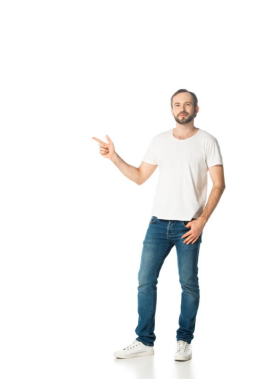

In [3]:
sample_image = cv2.imread(r'person.jpg')

plt.axis('off');plt.imshow(sample_image[:,:,::-1]);plt.show()


PERFORM POSE DETECTION

In [4]:
# Perform pose Detection
results = pose.process(cv2.cvtColor(sample_image,cv2.COLOR_BGR2RGB))

# check if landmarks are found
if results.pose_landmarks:
    for i in range(2):
        
        # display landmarks
        print(f"{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}")

NOSE:
x: 0.6963302
y: 0.2759014
z: -0.58265185
visibility: 0.9999212

LEFT_EYE_INNER:
x: 0.7119825
y: 0.26251954
z: -0.5476793
visibility: 0.9998491



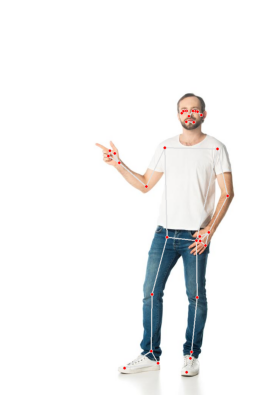

In [5]:
img_copy = sample_image.copy()

if results.pose_landmarks:
    mp_drawing.draw_landmarks(image=img_copy, landmark_list = results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    
    fig = plt.figure(figsize=(5,5))
    plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

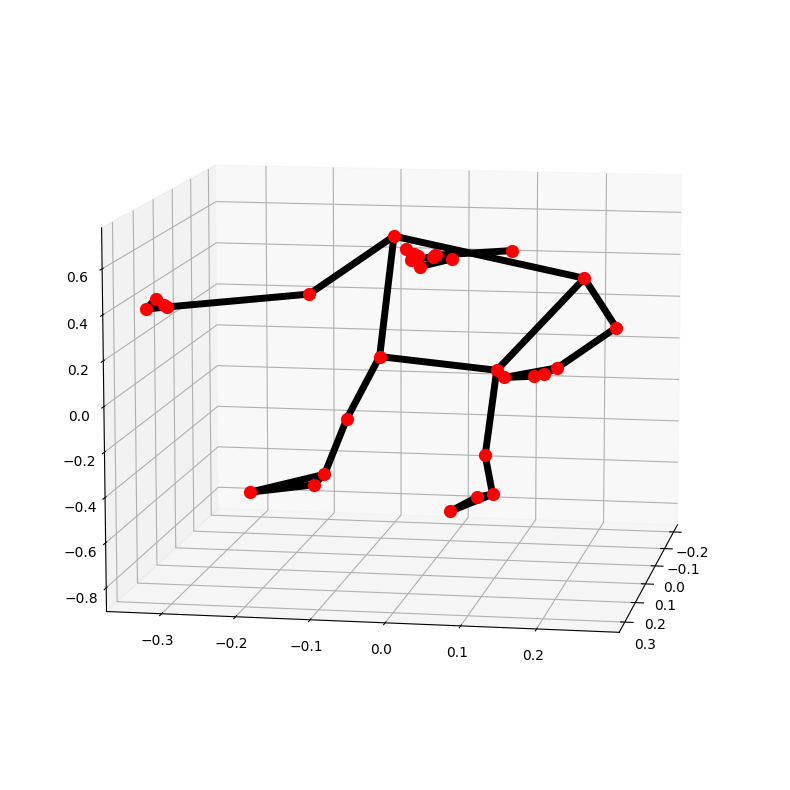

In [6]:
# plot 3D landmarks

mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

CREATE A POSE DETECTION FUNCTION

In [7]:
# Create functions for detecting angles

def calculate_angle(landmark1, landmark2, landmark3):
    
    x1,y1,_ = landmark1
    x2,y2,_ = landmark2
    x3,y3,_ = landmark3
    
    #calculate angle
    angle = math.degrees(math.atan2(y3-y2,x3-x2) - math.atan2(y1 - y2,x1 - x2))
    
    if angle < 0:
        angle += 360
        
    return angle

In [96]:
import csv

def detect_pose(image, pose, display=True, need_coords=False, class_name = 'default'):
    
    # Create a copy of image
    output_image = image.copy()
    
    # Convert image to RGB
    image_RGB = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection
    results = pose.process(image_RGB)
    
    height,width, _ = image.shape
    
    red = (0,0,255)
    green = (0,255,0)
    color = 0
    # list of detected landmarks
    landmarks = []
    if results.pose_landmarks:
        # draw pose landmarks
        mp_drawing.draw_landmarks(
            output_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(
                color = red,
                thickness=2,
                circle_radius=2
            ),
            mp_drawing.DrawingSpec(
                color=red,
                thickness=2,
                circle_radius=2
            )
        )   
        for landmark in results.pose_landmarks.landmark:
            
            # append landmarks
            landmarks.append([int(landmark.x*width), int(landmark.y * height),int(landmark.z*width)])
            
        if need_coords:
            
            # Get angle between the left shoulder, elbow and wrist points
            left_elbow_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
            
            # Get angle between the right shoulder, elbow and wrist points
            right_elbow_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])
            
            # Get angle between the left shoulder, elbow and hip points
            left_shoulder_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
            
            # Get angle between the right hip, shoulder and elbow points
            right_shoulder_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])
            
            # Get angle between the left hip, knee and ankle points
            left_knee_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
            
            # Get angle between the right hip, knee and ankle points
            right_knee_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
            
            angles = [left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_knee_angle,right_knee_angle]
            row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in results.pose_landmarks.landmark]).flatten())
            print(len(row))
            row.insert(0, class_name)
            row.extend(angles)
            print(len(row))
            # Export to CSV
            with open('poses_coords.csv', mode='a', newline='') as f:
                        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                        csv_writer.writerow(row)
                 
    if display:
        
        # display the original and output data
        plt.figure(figsize=(15,15))
        
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title('Original Image');plt.axis('off')
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title('Output Image');plt.axis('off')
        
        mp_drawing.plot_landmarks(results.pose_world_landmarks,mp_pose.POSE_CONNECTIONS)
    else:
        return output_image, landmarks

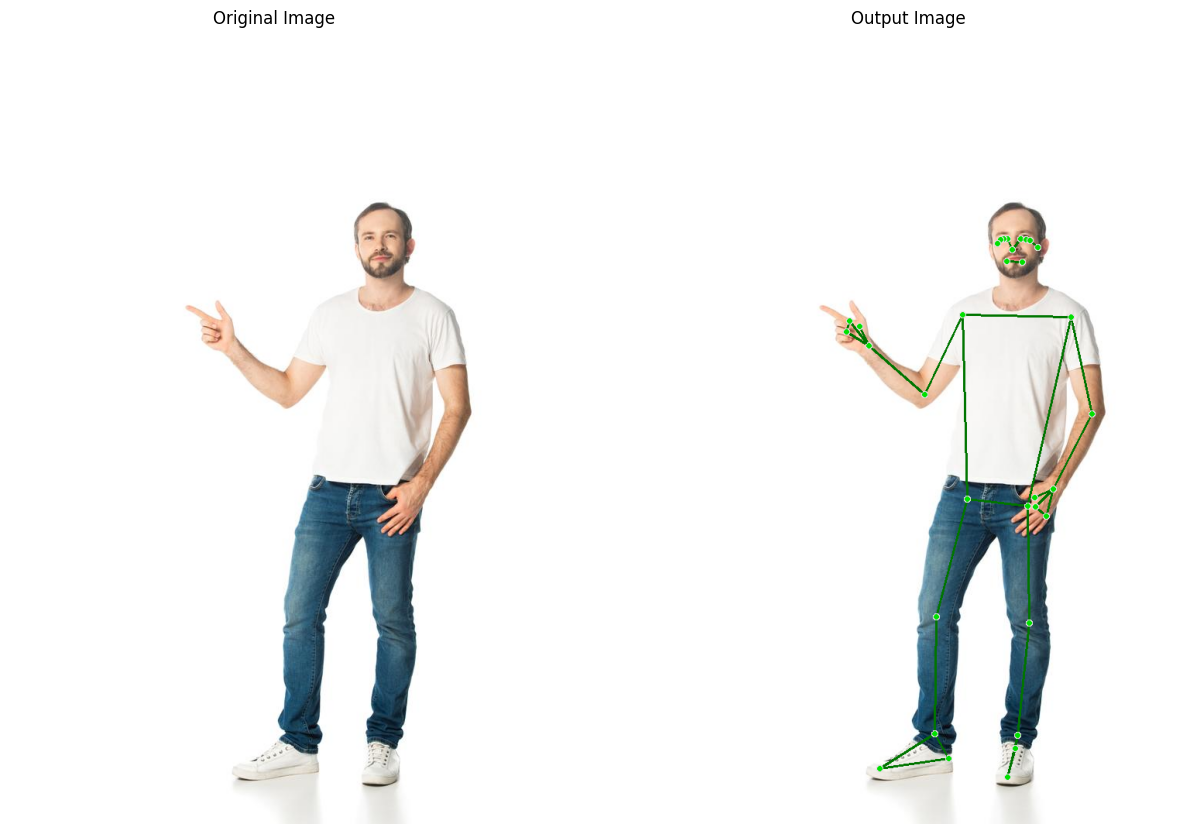

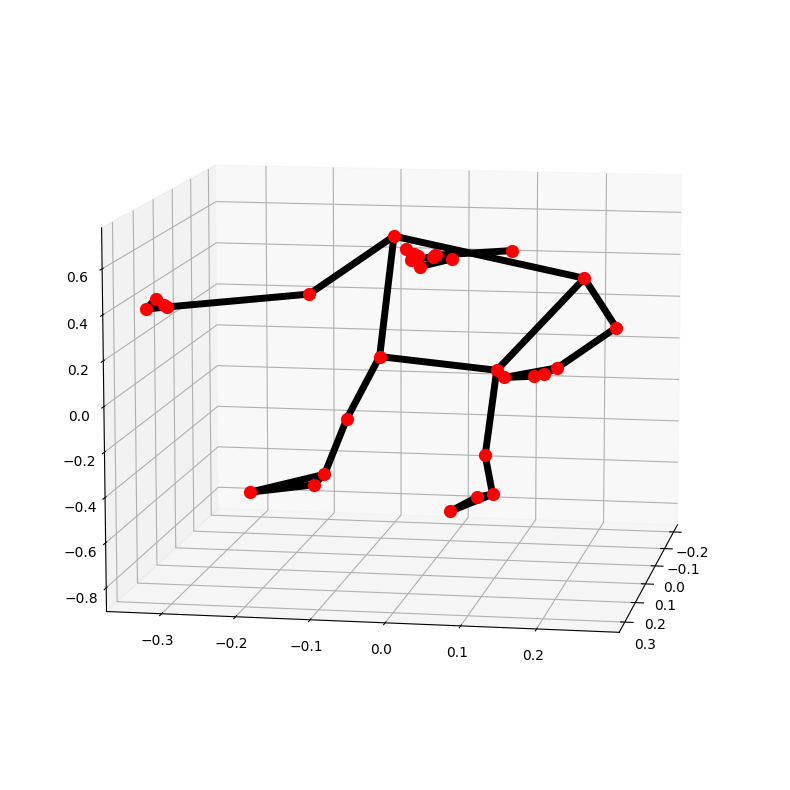

In [9]:
image = cv2.imread('person.jpg')
detect_pose(image,pose,display=True)

CREATING CSV FILE FOR RIGHT POSES

In [10]:
import csv
import csv
import pandas as pd

dict_landmarks = {
    0 : "nose",
    1 : "left_eye(inner)",
    2 : "left_eye",
    3 : "left_eye(outer)",
    4 : "right_eye(inner)",
    5 : "right_eye",
    6 : "right_eye(outer)",
    7 : "left_ear",
    8 : "right_ear",
    9 : "mouth(left)",
    10 : "mouth(right)",
    11 : "left_shoulder",
    12 : "right_shoulder",
    13 : "left_elbow",
    14 : "right_elbow",
    15 : "left_wrist",
    16 : "right_wrist",
    17 : "left_pinky",
    18 : "right_pinky",
    19 : "left_index",
    20 : "right_index",
    21 : "left_thumb",
    22 : "right_thumb",
    23 : "left_hip",
    24 : "right_hip",
    25 : "left_knee",
    26 : "right_knee",
    27 : "left_ankle",
    28 : "right_ankle",
    29 : "left_heel",
    30 : "right_heel",
    31 : "left_foot_index",
    32 : "right_foot_index"
}

def create_csv(name_of_file: str):
    num_coords = 33
    landmarks = ['class']
    
    for val in range(0, num_coords):
        landmarks += [
            f'x-{dict_landmarks[val]}',
            f'y-{dict_landmarks[val]}',
            f'z-{dict_landmarks[val]}',
            f'v-{dict_landmarks[val]}'
            ]
    with open(name_of_file, mode='w', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(landmarks)
        
    df = pd.read_csv(name_of_file)
    new_df = pd.concat([df,pd.DataFrame(columns=['left_elbow_angle',
            'right_elbow_angle',
            'left_shoulder_angle',
            'right_shoulder_angle',
            'left_knee_angle',
            'right_knee_angle'])],axis='columns')
    new_df.to_csv(name_of_file,index=False)
    
create_csv('poses_coords.csv')
df = pd.read_csv('poses_coords.csv')
df.shape

(0, 139)

CREATING FUNCTIONS FOR DETECT YOGA POSES FROM FOLDER 'POSES'

In [11]:
# creating function for getting coodrinates from video

def get_video(image_path,image_class):
    # pose function for video
    pose_video = mp_pose.Pose(static_image_mode=False,min_detection_confidence=0.5,model_complexity=1)

    # init the VideoCapture
    video = cv2.VideoCapture(image_path)

    while video.isOpened():
        ok , frame = video.read()
        if not ok:
            break
        
        # flip frame horizontaly
        frame = cv2.flip(frame, 1)

        frame_height, frame_width , _ = frame.shape
        
        frame = cv2.resize(frame,(int(frame_width*(640/frame_height)),640))
        
        # perform pose detection
        frame, landmarks = detect_pose(frame, pose_video ,display=False,need_coords=True,class_name=image_class)
        
        cv2.waitKey(0) 
   
    video.release()
    cv2.destroyAllWindows()

In [12]:
import os
import imghdr

def get_coordinates():   
    pose_dir = 'Poses'
    classes = os.listdir(pose_dir)

    video_formats = ['mp4']
    for image_class in os.listdir(pose_dir):
        for image in os.listdir(os.path.join(pose_dir,image_class)):
            image_path = os.path.join(pose_dir,image_class,image)
            tip = imghdr.what(image_path)
            print(image_path)
            if tip not in video_formats:
                    img = cv2.imread(image_path)
                    output_image, landmarks = detect_pose(img, pose, display=False,need_coords=True,class_name=image_class)
            else:
                get_video(image_path,image_class)


get_coordinates()             

C:\Users\Polina\AppData\Local\Temp\ipykernel_316\2845868128.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Poses\Dog\1920x1080_DownwardFacingDogPose.jpg
132
139
Poses\Dog\7019-downward.jpg
132
139
Poses\Dog\bird-dog-pose-1.jpg
132
139
Poses\Dog\Dog1.webp
132
139
Poses\Dog\downDog_9650.jpg
132
139
Poses\Dog\downward+dog.jpeg
132
139
Poses\Dog\downward-facing-dog-1600x900.jpg
132
139
Poses\Dog\downward-facing-dog-adho-mukha-svanasana-2021-08-26-15-32-21-utc.jpg
132
139
Poses\Dog\downward-facing-dog-pose-1024x683.png
132
139
Poses\Dog\Downward-Facing-Dog-Pose-Adho-Mukha-Svanasana.jpg
132
139
Poses\Dog\Downward-Facing-Dog-Pose_Andrew-Clark_2400x1350.jpeg
132
139
Poses\Dog\Sides-479-of-523.jpg
132
139
Poses\Dog\stacey-yoga.jpg
132
139
Poses\Dog\threedog5.jpg
132
139
Poses\Tree\19983630-yoga-tree-pose-by-indian-man-in-black-costume-mudra-isolated-at-white-background.jpg
132
139
Poses\Tree\HowToDoTreePose.jpg
132
139
Poses\Tree\I4A7694-scaled.webp
132
139
Poses\Tree\tree-pose.jpg
132
139
Poses\Tree\Tree-Pose_Alt-1_2400x1350_Andrew-Clark.jpeg
132
139
Poses\Tree\Tree_1.jpg
132
139
Poses\Tree\Yoga_Tr

BUILD SIMPLE MLP MODEL

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('poses_coords.csv')
df.head()

,class,x-nose,y-nose,z-nose,v-nose,x-left_eye(inner),y-left_eye(inner),z-left_eye(inner),v-left_eye(inner),x-left_eye,...,x-right_foot_index,y-right_foot_index,z-right_foot_index,v-right_foot_index,left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_knee_angle,right_knee_angle
0,Dog,0.551525,0.679763,-0.057471,0.997036,0.569217,0.694630,-0.038422,0.985211,0.573047,...,0.244199,0.838640,-0.192675,0.944813,165.337761,159.970060,172.483497,193.185848,175.637920,177.656417
1,Dog,0.490614,0.819926,-0.069553,0.998062,0.510659,0.845465,-0.054815,0.994885,0.513906,...,0.195337,0.956971,-0.291376,0.770573,175.386183,176.723625,202.567099,155.486350,177.397657,178.666479
2,Dog,0.392920,0.367483,-0.445276,0.998445,0.383597,0.341164,-0.479530,0.995838,0.386401,...,0.899562,0.385444,1.014664,0.129807,202.806339,165.793727,226.192885,100.212473,66.137343,177.070753
3,Dog,0.539042,0.656386,-0.012095,0.995713,0.551268,0.665882,-0.001792,0.984275,0.553420,...,0.371567,0.821555,-0.156942,0.909839,173.135775,169.424140,167.272410,196.837473,183.551199,182.754919
4,Dog,0.613782,0.690345,-0.082469,0.996949,0.638884,0.691107,-0.055131,0.987917,0.641453,...,0.161921,0.834430,-0.243933,0.911819,176.185925,165.147757,175.412022,189.716822,177.475294,181.679379


In [14]:
df[df['class']=='Dog'].shape

(14, 139)

In [15]:
df[df['class']=='Tree'].shape

(7, 139)

In [30]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
num_classes = 2

X = df.drop('class', axis=1) # features
y = df['class'] # target value


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [59]:
X_train.iloc[1:2,:].to_numpy().shape

(1, 138)

In [26]:
X_train.shape

(16, 138)

CREATE SIMPLE MLP

In [38]:
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

transformer = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    remainder='passthrough'
)

pipelines = {
    'lr':make_pipeline(transformer, LogisticRegression(max_iter=1000)),
    'rc':make_pipeline(transformer, RidgeClassifier()),
    'rf':make_pipeline(transformer, RandomForestClassifier()),
    'gb':make_pipeline(transformer, GradientBoostingClassifier()),
}

fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

In [70]:
X_test

,x-nose,y-nose,z-nose,v-nose,x-left_eye(inner),y-left_eye(inner),z-left_eye(inner),v-left_eye(inner),x-left_eye,y-left_eye,...,x-right_foot_index,y-right_foot_index,z-right_foot_index,v-right_foot_index,left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_knee_angle,right_knee_angle
3,0.539042,0.656386,-0.012095,0.995713,0.551268,0.665882,-0.001792,0.984275,0.553420,0.663994,...,0.371567,0.821555,-0.156942,0.909839,173.135775,169.424140,167.272410,196.837473,183.551199,182.754919
13,0.503251,0.718409,-0.034523,0.999908,0.515953,0.727214,-0.026997,0.999597,0.518304,0.725813,...,0.077037,0.193335,-0.257118,0.999417,159.227745,164.235989,160.043136,197.146446,173.042501,189.269098
2,0.392920,0.367483,-0.445276,0.998445,0.383597,0.341164,-0.479530,0.995838,0.386401,0.333936,...,0.899562,0.385444,1.014664,0.129807,202.806339,165.793727,226.192885,100.212473,66.137343,177.070753
16,0.545662,0.178537,-0.276008,0.998046,0.548864,0.160332,-0.253176,0.998730,0.553049,0.160838,...,0.534015,0.686035,0.257733,0.498908,322.164636,54.215213,22.842362,17.814414,182.045313,27.747470
14,0.508365,0.240629,-0.490082,0.999934,0.519636,0.225733,-0.436733,0.999953,0.530352,0.226465,...,0.513169,0.674768,-0.074679,0.611366,316.564679,41.030737,43.550929,22.603487,178.670164,25.870008


In [76]:
from sklearn.metrics import f1_score # Accuracy metrics 
import pickle

y_test = label_encoder.fit_transform(y_test)

for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    yhat = label_encoder.fit_transform(yhat)
    print(algo, f1_score(y_test, yhat))

lr 0.8
rc 1.0
rf 0.8
gb 0.8


In [40]:
with open('body_language.pkl', 'wb') as f:
    pickle.dump(fit_models['rc'], f)

POSE DETECTION ON REAL-TIME VIDEO OR WEBCAM

In [41]:
with open('body_language.pkl', 'rb') as f:
    model = pickle.load(f)

In [42]:
def detect_row(pose_landmarks,height,width):
    
        landmarks = []
        for landmark in pose_landmarks:     
                
            # append landmarks
            landmarks.append([int(landmark.x*width), int(landmark.y * height),int(landmark.z*width)])

            
            # Get angle between the left shoulder, elbow and wrist points
        left_elbow_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
            
            # Get angle between the right shoulder, elbow and wrist points
        right_elbow_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])
            
            # Get angle between the left shoulder, elbow and hip points
        left_shoulder_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
            
            # Get angle between the right hip, shoulder and elbow points
        right_shoulder_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])
            
            # Get angle between the left hip, knee and ankle points
        left_knee_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                            landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
            
            # Get angle between the right hip, knee and ankle points
        right_knee_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                            landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
            
        angles = [left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_knee_angle,right_knee_angle]
        row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in results.pose_landmarks.landmark]).flatten())
        print(len(row))
        row.extend(angles)
        
        return row

In [95]:
# pose function for video
pose_video = mp_pose.Pose(static_image_mode=False,min_detection_confidence=0.5,model_complexity=1)

# init the VideoCapture
video = cv2.VideoCapture(0)

# Create named Window
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)

# set video Camera Size
video.set(3,1280)
video.set(4,960)

# variable for time of a previous frame
time1=0

while video.isOpened():
    
    ok , frame = video.read()
    if not ok:
        break
    
    # flip frame horizontaly
    frame = cv2.flip(frame,1)

    frame_height, frame_width , _ = frame.shape
    
    frame = cv2.resize(frame,(int(frame_width*(640/frame_height)),640))
    
    # perform pose detection
    frame, _ = detect_pose(frame, pose_video , display=False)
    
    # Convert image to RGB
    image_RGB = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection
    results = pose.process(image_RGB)
    try:
        
        row = detect_row(results.pose_landmarks.landmark,frame_height,frame_width)
        # Make Detections
        X = pd.DataFrame(np.array([row]),columns=X_train.columns)
        body_language_class = model.predict(X)[0]
        body_language_prob = model.predict_proba(X)[0][0]
        
        print(body_language_class, body_language_prob)
        if body_language_prob > 0.89:
                frame, _ = detect_pose(frame, pose_video , display=False,color='green')
        # Grab ear coords
        coords = tuple(np.multiply(
                                np.array(
                                    (results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].x, 
                                    results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].y))
                            , [640,480]).astype(int))
                
        cv2.rectangle(image, 
                            (coords[0], coords[1]+5), 
                            (coords[0]+len(body_language_class)*20, coords[1]-30), 
                            (245, 117, 16), -1)
        cv2.putText(image, body_language_class, coords, 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
                # Get status box
        cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
                
                # Display Class
        cv2.putText(image, 'CLASS'
                            , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(image, body_language_class.split(' ')[0]
                            , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
                # Display Probability
        cv2.putText(image, 'PROB'
                            , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2))
                            , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        time2 = time()
            
        if (time2 - time1) > 0: 
                frame_per_second = 1.0 / (time2 - time1)
                cv2.putText(
                    frame,
                    f'FPS : {int(frame_per_second)}',
                    (10, 30),
                    cv2.FONT_HERSHEY_PLAIN,
                    2,
                    (0, 250, 0),
                    3,
                )
                
            # update time    
        time1 = time2
    except:
        pass
    cv2.imshow('Pose Detection',frame)
    
    k = cv2.waitKey(1) & 0xFF
    
    # if we press ESC
    if (k==27):
        break
    
video.release()

cv2.destroyAllWindows()

132
Dog 0.9977661919405468
132
Dog 0.8886797827939772
132
Dog 0.9469900715227798
132
Dog 0.9469900715227798
132
Dog 0.9993441461945762
132
Dog 0.9469900715227798
132
Dog 0.9469900715227798
132
Dog 0.9904549340797838
132
Dog 0.9469900715227798
132
Dog 0.9990001616763698
132
Dog 0.9993441461945762
132
Dog 0.6071061529149393
132
Dog 0.9469900715227798
132
Dog 0.9469900715227798
132
Dog 0.9469900715227798
132
Dog 0.9360037510747661
132
Dog 0.9360037510747661
132
Dog 0.9990001616763698
132
Dog 0.9871627088686368
132
Dog 0.9993441461945762
132
Dog 0.9469900715227798
132
Dog 0.9990001616763698
132
Dog 0.9871627088686368
132
Dog 0.9042922127386315
132
Tree 0.2648868772192504
132
Dog 0.9942201791884
132
Dog 0.9971058574392091
132
Tree 0.46852138710449354
132
Tree 0.46852138710449354
132
Tree 0.46852138710449354
132
Dog 0.9993441461945762
132
Dog 0.914310302798717
132
Tree 0.46852138710449354
132
Tree 0.46852138710449354
132
Tree 0.3688011799308831
132
Tree 0.4191923082105612
132
Tree 0.41919230